In [4]:


import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Tuple, List, Union
from scipy.special import logit, expit
from ipywidgets import Box, Button, Dropdown, HBox, VBox, ToggleButtons, GridBox, Label, Text, Layout
from ipycanvas import Canvas, hold_canvas, Path2D
import traitlets as T
from time import sleep
from scipy.stats import norm

In [6]:
resource_colors = {
    "oil": {"r": 0, "g": 50, "b": 50},
    "coal": {"r": 0, "g": 0, "b": 0},
    "wood": {"r": 200, "g": 100, "b": 50},
    "uranium": {"r": 100, "g": 130, "b": 100},
    "gold": {"r": 250, "g": 200, "b": 100},
    "copper": {"r": 200, "g": 100, "b": 50},
  }

def get_resource_color(resource: str) -> Tuple[int, int, int]:
  if resource not in resource_colors:
    raise ValueError(f"{resource} is not a valid resource")

  return (resource_colors[resource]["r"],
          resource_colors[resource]["g"],
          resource_colors[resource]["b"])

class World():
  def __init__(
      self,
      world_width:int = 60,
      world_height:int = 400,
      canvas_width:float = 600,
      canvas_height:float = 400,
      ground_canvas_height:float = 50,
      message = "Prepare your defenses"
    ):
    self.world_width = world_width
    self.world_height = world_height
    self.canvas_width = canvas_width
    self.canvas_height = canvas_height
    self.patch_width = canvas_width / world_width
    self.patch_height = canvas_height / world_height
    self.ground_canvas_height = ground_canvas_height
    self.ground_world_height = int(ground_canvas_height / self.patch_height)
    self.message = message

  def cx_to_wx(self, cx: float) -> int:
    return int(cx / self.patch_width)

  def cy_to_wy(self, cy: float) -> int:
    return int(cy / self.patch_height)

  def wx_to_cx(self, wx: float) -> float:
    return wx * self.patch_width

  def wy_to_cy(self, wy: float) -> float:
    return wy * self.patch_height

  def set_message(self, message: str):
    self.message = message

  def clear_message(self):
    self.message = ""

  def draw(self, canvas:Canvas):
    # draw sky
    canvas.stroke_style = "skyblue"
    canvas.fill_style = "skyblue"
    canvas.fill_rect(0, 0, self.canvas_width, self.canvas_height - self.ground_canvas_height)
    if len(self.message) > 0:
      canvas.fill_style = "black"
      canvas.font = "30px monospace"
      canvas.text_align = "center"
      canvas.text_baseline = "top"
      canvas.fill_text(self.message, self.canvas_width / 2, 10)

class Trap():
  def __init__(
      self,
      internal_materials: pd.Series,
      external_materials: pd.Series,
      owner, #: Union[Ground, Alien],
      owner_world_x_offset: int,
      owner_world_y_offset: int,
    ):
    self.internal_materials = internal_materials
    self.external_materials = external_materials
    self.owner = owner
    self.owner_world_x_offset = owner_world_x_offset
    self.owner_world_y_offset = owner_world_y_offset

  def update_materials(self, internal_materials: pd.Series, external_materials: pd.Series):
    self.internal_materials = internal_materials
    self.external_materials = external_materials

  def draw(self, canvas: Canvas, world: World):
    pw = world.patch_width
    owner_world_x = self.owner.world_x if "world_x" in dir(self.owner) else 0
    owner_world_y = self.owner.world_y if "world_y" in dir(self.owner) else 0

    cx = world.wx_to_cx(owner_world_x + self.owner_world_x_offset)
    cy = world.wy_to_cy(owner_world_y + self.owner_world_y_offset)
    # print("trap", wx, wy)
    #outside
    canvas.fill_style = "#ff0000"
    canvas.fill_rect(cx - pw / 2, cy - pw / 2, pw * 2, pw * 2)
    #inside
    canvas.fill_style = "#00ff00"
    canvas.fill_rect(cx, cy, pw, pw)





class Ground():
  def __init__(self, world: World):
    self.world_y = (world.world_height - world.ground_world_height)
    ww = world.world_width
    self.health = np.ones(ww)
    self.resources = pd.DataFrame({
        "oil": self.get_distribution(size=ww),
        "coal": self.get_distribution(size=ww),
        "wood": self.get_distribution(size=ww),
        "uranium": self.get_distribution(size=ww),
        "gold": self.get_distribution(size=ww),
        "copper": self.get_distribution(size=ww),
    })
    self.resources.astype(float) #{"health": float})
    self.display = "health"
    self.traps = {}

  def get_distribution(self, size: int, min_deposits = 1, max_deposits = 5) -> np.ndarray:
    deposits = np.random.randint(min_deposits, max_deposits+1)
    # create spread deposits with a range of total resources
    final_distribution = np.zeros(size)
    for _ in range(deposits):
      resource_total = np.random.randint(10, 50)
      resource_spread = np.random.uniform(
          resource_total / 15, resource_total / 5)

      # create the spread across three "screens", then collapse to middle
      center = np.random.randint(0, size)
      # center = 50 * 3
      normal_dist = norm(loc=center + size, scale=resource_spread)
      distribution = normal_dist.pdf(range(size * 3))
      distribution /= distribution.sum()
      distribution *= resource_total
      # get the center
      final_distribution += distribution[size:size*2]
    return final_distribution

  def get_random_distribution(self, size: int):
    # return np.random.random(size=size) * size
    return np.random.normal(0.5, 0.1, size=size)

  def get_n(self):
    return self.resources.shape[0]

  def get_resource_names(self) -> List[str]:
    return self.resources.columns.tolist()

  def get_resources_at_world_x(self, world_x: int) -> pd.Series:
    return self.resources.iloc[world_x, :]

  def get_health_at_world_x(self, world_x: int) -> float|int:
    return self.health[world_x]

  def get_resource_at_world_x(self, resource: str, world_x: int) -> float|int:
    return self.resources[resource][world_x]

  def set_health_at_world_x(self, world_x: int, value: float):
    self.health[world_x] = value

  def set_resource_at_world_x(self, resource: str, world_x: int, value: float):
    self.resources[resource][world_x] = value

  def set_display(self, display: str):
    self.display = display

  def add_trap_at_world_x(
      self,
      trap: Trap,
      world_x: int
    ):
    trap.owner = self
    self.traps[world_x] = trap

  def get_trap_at_world_x(self, world_x: int) -> Optional[Trap]:
    if world_x in self.traps:
      return self.traps[world_x]
    else:
      return None

  def remove_trap_at_world_x(self, world_x: int) -> Optional[Trap]:
    if world_x in self.traps:
      trap = self.traps[world_x]
      trap.owner = None
      del self.traps[world_x]
      return trap
    else:
      return None

  def remove_all_traps(self):
    self.traps = {}

  def draw(self, canvas: Canvas, world: World):
    pw = world.patch_width


    if self.display != "health":
      values = self.resources[self.display]
      values = values / max(1, values.max())
    else:
      values = self.health

    for wx in list(range(len(values))):
      value = values[wx]
      if self.display == "health":
        rval = 120 - int(value * 100)
        gval = 50 + int(value * 120)
        bval = 20
      else:
        r, g, b = get_resource_color(self.display)
        rval = 255 - int((255 - r) * value)
        gval = 255 - int((255 - g) * value)
        bval = 255 - int((255 - b) * value)

      canvas.stroke_style = f"rgb({rval}, {gval}, {bval})"
      canvas.fill_style = f"rgb({rval}, {gval}, {bval})"
      canvas.fill_rect(pw * wx, world.canvas_height - world.ground_canvas_height, pw, world.ground_canvas_height)

    # draw all traps on ground
    for wx, trap in self.traps.items():
      trap.draw(canvas, world)


class Alien():
  def __init__(self, world_x: int, world_y: int, world: World, resource_preferences: pd.Series):
    self.world_x = world_x
    self.world_y = world_y
    self.world_width = 2
    self.world_height = 10
    self.mother_world_x = world.world_width / 2
    self.mother_world_y = 0
    self.resource_preferences = resource_preferences
    self.trap: Optional[Trap] = None

  def get_world_pos(self) -> Tuple[int, int]:
    return self.world_x, self.world_y

  def move_to(self, world_x: int, world_y: int):
    self.world_x = world_x
    self.world_y = world_y

  def ascend(self, world_dy: int = 1):
    # self.world_x -= int((self.world_x - self.mother_world_x) / 2)
    self.world_y -= world_dy

  def descend(self, world_dy: int = 1):
    self.world_y += world_dy

  def wants_trap(self, trap: Trap) -> bool:
    # include only materials present in the external
    materials = trap.external_materials[trap.external_materials > 0]
    # materials in the trap are considered proportional
    materials = materials / materials.sum()

    n_preferred = sum(self.resource_preferences > 0)
    material_preferences = self.resource_preferences.loc[materials.index]
    # print("preference for these materials", material_preferences)
    dev = materials.subtract(self.resource_preferences, level=0)
    rmsq = ((dev ** 2).sum(skipna=True) / (len(materials))) ** 0.5
    print("deviations", dev.dropna())
    print("rmsq", rmsq)
    # lik = materials.mul(self.resource_preferences, level=0).sum(skipna=True)
    # print(lik)
    # return True if lik > 1 else False
    return True if rmsq < 0.1 else False

  def allergic_to_trap(self) -> Optional[bool]:
    if self.trap is not None:
      # include only materials present in the internal
      materials = self.trap.internal_materials[self.trap.internal_materials > 0]
      # materials in the trap are considered proportional, include -1 to align to prefs
      materials = -1 * materials / materials.sum()
      n_preferred = sum(self.resource_preferences < 0)

      material_preferences = self.resource_preferences.loc[materials.index]
      dev = materials.subtract(self.resource_preferences, level=0)
      rmsq = ((dev ** 2).sum(skipna=True) / (len(materials))) ** 0.5
      print("deviations", dev.dropna())
      print("rmsq", rmsq)
      return True if rmsq < 0.1 else False
      # lik = materials.mul(self.resource_preferences, level=0).sum(skipna=True)
      # return True if lik < -1 else False
    else:
      return None

  def take_trap(self, trap: Trap):
    trap.owner = self
    trap.owner_world_x_offset = 0
    trap.owner_world_y_offset = 0
    self.trap = trap

  def draw(self, canvas: Canvas, world: World):
    """
    world_x_to_canvas: conversion from world x to canvas x
    """
    canvas.fill_style = "#335554"
    canvas.stroke_style = "#ff9999"
    cw = world.wx_to_cx(self.world_width)
    ch = world.wy_to_cy(self.world_height)
    # the cx, cy position is the bottom-left of the bounding box on the canvas
    cx = world.wx_to_cx(self.world_x) + (world.patch_width - cw) / 2
    cy = world.wy_to_cy(self.world_y)
    if cy >= 0:
      # cx += world.patch_width - cw / 2
      try:
        canvas.begin_path()
        canvas.move_to(cx, cy)
        canvas.bezier_curve_to(cx, cy - ch, cx + cw, cy - ch, cx + cw, cy)
        canvas.close_path()
        canvas.fill()
        canvas.stroke()
      except:
        raise Exception("Couldn't draw path at", cx, cy)

      if self.trap is not None:
        self.trap.draw(canvas, world)

class Aliens():
  def __init__(self, ground: Ground, probability_cutoff: float = 0.6):
    self.max_aliens = 20
    self.aliens = None

    ### determine the alien's preference for each resource
    resources = ground.get_resource_names()
    resource_preferences = pd.Series([0] * len(resources), index=resources)

    # determine how many resources aliens like and don't like, then assign values
    like_n = np.random.choice([1, 2, 3])
    dislike_n = np.random.choice([1, 2, 3])

    resources_liked = np.random.choice(resources, size=like_n, replace=False)
    resources_left = list(set(resources).difference(set(resources_liked)))
    resources_disliked = np.random.choice(resources_left, size=dislike_n, replace=False)

    liked = np.random.uniform(low=0.1, high=1.0, size=len(resources_liked))
    liked = liked / sum(liked) # positive preferences should sum to one
    resource_preferences.loc[resources_liked] = liked

    disliked = np.random.uniform(low=-1.0, high=-0.1, size=len(resources_disliked))
    disliked = -1 * disliked / sum(disliked) # positive preferences should sum to one
    resource_preferences.loc[resources_disliked] = disliked

    self.resource_preferences = resource_preferences

  def spawn_all(self, ground: Ground, world: World):
    aliens = []
    likelihoods = self.likelihood_by_world_x(ground.resources)
    # sort likelihoods and use index as world_x
    likelihoods = likelihoods.sort_values(ascending=False)[0:self.max_aliens]
    for world_x in likelihoods.index.to_list():
      aliens.append(
          Alien(
              world_x,
              np.random.randint(-world.ground_world_height, 0),
              world,
              self.resource_preferences
          )
        )

    self.aliens = aliens

  def kill_all(self):
    self.aliens = None

  def likelihood_by_world_x(self, resources: pd.DataFrame, noise: float = 0.01) -> pd.Series:
    # for each resource, divide by the total
    standardized_resources = resources / resources.agg('sum', axis=0, skipna=True)
    def multiply_by_preferences(resources: pd.Series) -> pd.Series:
      return (self.resource_preferences * resources).sum(skipna=True)

    likelihoods = standardized_resources.agg(multiply_by_preferences, axis=1)
    likelihoods += np.random.normal(0, scale=noise, size=resources.shape[0])
    return pd.Series(likelihoods, index=resources.index)


  def likelihood_by_resources(self, resources: pd.Series, noise: float = 0.01) -> float:
    likelihood = np.random.normal(0, scale=noise)
    preferences = self.resource_preferences * resources
    likelihood += preferences.sum()
    return likelihood

  def get_n(self):
    return len(self.aliens) if self.aliens is not None else 0

  def get_world_pos_at_index(self, index: int) -> Optional[Tuple]:
    return self.aliens[index].get_world_pos() \
      if self.aliens is not None else None

  def get_all_world_pos(self) -> Optional[List[Tuple]]:
    return [alien.get_world_pos() for alien in self.aliens] \
      if self.aliens is not None else None

  def ascend(self, world_dy: int = 1):
    if self.aliens is not None:
      for alien in self.aliens:
        alien.ascend(world_dy)

  def descend(self, world_dy: int = 1):
    if self.aliens is not None:
      for alien in self.aliens:
        alien.descend(world_dy)

  def delete_at_index(self, index:int):
    if self.aliens is not None:
      del self.aliens[index]

  def allergic_to_traps(self) -> Optional[bool]:
    any_allergic = None
    if self.aliens is not None:
      for alien in self.aliens:
        allergic = alien.allergic_to_trap()
        if allergic is True:
          return True
        elif allergic is False:
          any_allergic = False
    return any_allergic


  def draw(self, canvas: Canvas, world: World):
    if self.aliens is not None:
      for alien in self.aliens:
        alien.draw(canvas, world)



class DefenseShot():
  def __init__(self, world_x: int, world_y: int):
    self.world_x = world_x
    self.world_y = world_y

  def move_to(self, world_x: int, world_y: int):
    self.world_x = world_x
    self.world_y = world_y

  def ascend(self, world_dy: int = 1):
    self.world_y -= world_dy

  def draw(self, canvas: Canvas, world: World):
    if self.world_y >= 0:
      canvas.fill_style = "#000000"
      canvas.stroke_style = "#ffff88"
      cd = 4
      cx = world.wx_to_cx(self.world_x) + (world.patch_width - cd) / 2
      cy = world.wy_to_cy(self.world_y)
      canvas.fill_circle(cx, cy, cd)
      canvas.stroke_circle(cx, cy, cd)




class Defense():
  def __init__(self, world_x: int, world_y: int):
    self.world_x = world_x
    self.world_y = world_y
    self.shot = None
    self.is_selected = False

  def has_shot(self):
    return False if self.shot is None else True

  def generate_shot(self):
    self.shot = DefenseShot(self.world_x, self.world_y)

  def move_to_x(self, world_x: int):
    self.world_x = world_x

  def ascend_shot(self, world_dy: int = 1):
    if self.shot is not None:
      self.shot.ascend(world_dy)

  def get_shot_world_pos(self) -> Optional[Tuple[int, int]]:
    if self.shot is None:
      return None
    else:
      return self.shot.world_x, self.shot.world_y

  def delete_shot(self):
    self.shot = None

  def is_canvas_point_inside(self, cx: float, cy: float, world: World) -> bool:
    self_cx = world.wx_to_cx(self.world_x)
    self_cy = world.wy_to_cy(self.world_y)
    if ((cx >= self_cx) and
        (cx <= (self_cx + world.patch_width)) and
        (cy >= self_cy) and
        (cy <= (self_cy + world.ground_canvas_height))
    ):
      return True
    else:
      return False

  def draw(self, canvas: Canvas, world: World):
    canvas.fill_style = "#666666"
    canvas.stroke_style = "#444444"
    # general
    pw = world.patch_width
    base_cw = pw * 1
    base_ch = base_cw
    barrel_cw = pw * 0.2
    barrel_ch = pw
    y_offset = 10

    # base
    canvas.begin_path()
    cx = world.wx_to_cx(self.world_x) + (pw - base_cw) / 2
    cy = world.wy_to_cy(self.world_y) + y_offset
    canvas.move_to(cx, cy)
    cx += (base_cw - barrel_cw) / 2
    cy -= base_ch
    canvas.line_to(cx, cy)
    cx += barrel_cw
    canvas.line_to(cx, cy)
    cx += (base_cw - barrel_cw) / 2
    cy += base_ch
    canvas.line_to(cx, cy)
    canvas.close_path()
    canvas.fill()
    canvas.stroke()
    # barrel
    canvas.begin_path()
    cx = world.wx_to_cx(self.world_x) + (pw - barrel_cw) / 2
    cy = world.wy_to_cy(self.world_y) - base_ch + y_offset
    canvas.move_to(cx, cy)
    cx += barrel_cw
    canvas.line_to(cx, cy)
    cy -= barrel_ch
    canvas.line_to(cx, cy)
    cx -= barrel_cw
    canvas.line_to(cx, cy)
    canvas.close_path()
    canvas.fill()
    canvas.stroke()
    if self.shot is not None:
      self.shot.draw(canvas, world)


class Defenses():
  def __init__(self, n_defense:int, world: World):
    wx = np.random.choice(np.linspace(0, world.world_width, world.world_width, endpoint=False), size=n_defense)
    self.world_y = world.world_height - world.ground_world_height
    wy = [self.world_y] * n_defense
    defenses = []
    for i in range(n_defense):
      defenses.append(Defense(wx[i], wy[i]))
    self.defenses: List[Defense] = defenses

  def add_at_world_x(self, world_x: int):
    self.defenses.append(Defense(world_x, self.world_y))

  def generate_shots(self):
    for defense in self.defenses:
      defense.generate_shot()

  def has_shot_at_index(self, index: int):
    return self.defenses[index].has_shot()

  def get_n(self):
    return len(self.defenses)

  def get_shot_world_pos_at_index(self, index: int) -> Optional[Tuple]:
    return self.defenses[index].get_shot_world_pos()

  def move_to_x_at_index(self, index: int, world_x: int):
    self.defenses[index].move_to_x(world_x)

  def ascend_shots(self, world_dy: int = 1):
    for defense in self.defenses:
      defense.ascend_shot(world_dy)

  def delete_at_index(self, index:int):
    del self.defenses[index]

  def search_at_world_x(self, world_x: int) -> Optional[int]:
    for index, defense in enumerate(self.defenses):
      if int(defense.world_x) == int(world_x):
        return index
    return None

  def search_at_canvas_point(self, cx: float, cy: float, world: World) -> Optional[int]:
    for index, defense in enumerate(self.defenses):
      if defense.is_canvas_point_inside(cx, cy, world):
        return index
    return None

  def delete_at_canvas_point(self, cx: float, cy: float, world: World) -> bool:
    index = self.search_at_canvas_point(cx, cy, world)
    if index is not None:
      del self.defenses[index]
      return True
    else:
      return False

  def delete_shot_at_index(self, index:int):
    self.defenses[index].delete_shot()

  def draw(self, canvas: Canvas, world: World):
    for defense in self.defenses:
      defense.draw(canvas, world)



class Game():
  def __init__(self, width=1000, height=400, n_patches=100, ground_height=50):

    ### World Objects
    self.world = World(
        world_width = n_patches,
        world_height = height,
        canvas_width = width,
        canvas_height = height
    )
    self.game_over = False
    self.max_defenses = 10
    self.current_defenses = 5
    self.__ground = Ground(self.world)
    self.__defenses = Defenses(self.current_defenses, self.world)
    self.__aliens = Aliens(self.__ground)
    resources = self.__ground.get_resource_names()
    # animation changes need to be accessible to the outside
    self.__is_animating = False
    self.__animation_callbacks = []

    ### Canvas and other Widgets
    self.canvas = Canvas(width=width, height=height)
    self.canvas.on_msg(self.handle_canvas_event)

    self.play_button = Button(description="Play", button_style="success")
    self.play_button.on_click(self.animate_step)

    self.interaction_mode_toggle = ToggleButtons(
        options=["cannons", "trap"],
        value=None,
        button_style="primary"
    )
    self.interaction_mode_toggle.observe(self.handle_interaction_mode_toggle_change)

    ground_display_dropdown = Dropdown(
        options=["health"] + self.__ground.get_resource_names(),
        value="health",
        button_style="info"
    )
    ground_display_dropdown.observe(self.handle_resource_dropdown_change)

    self.world.set_message("Set your cannons!")

    hbox = HBox([self.play_button,
                 self.interaction_mode_toggle,
                 ground_display_dropdown])

    surrender_button = Button(description="Surrender", button_style="danger")
    surrender_button.on_click(lambda _x: self.end_game(False))


    ### Table for resources used in trap
    grid_items:List[Label|Text] = [Label("Trap"), Label("Outside"), Label("Inside")]
    resource_names = self.__ground.get_resource_names()
    for resource in resource_names:
      grid_items.append(Label(value=resource))
      grid_items.append(Text(value="0"))
      grid_items.append(Text(value="0"))
    self.trap_table = GridBox(
        children=grid_items,
        layout=Layout(grid_template_columns="repeat(3, 100px)"))

    vbox = VBox([self.canvas, hbox, surrender_button, self.trap_table])

    display(vbox)

    ### Draw
    self.hold_draw(sleep=None)

  @property
  def is_animating(self):
    return self.__is_animating

  @is_animating.setter
  def is_animating(self, value):
    old_value = self.__is_animating
    self.__is_animating = value
    for callback in self.__animation_callbacks:
      callback(old_value, value)

  def add_animation_callback(self, callback):
    self.__animation_callbacks.append(callback)

  def send_cannon_message(self, draw: bool = True):
    if self.current_defenses < self.max_defenses:
      self.world.set_message(
          f"Set your cannons ({self.max_defenses - self.current_defenses} left)"
        )
    else:
      self.world.set_message("Click a cannon to remove and replace")
    if draw:
      self.hold_draw()

  def send_trap_message(self, draw: bool = True):
    self.world.set_message(
        f"Set the trap trap!"
      )
    if draw:
      self.hold_draw(sleep=None)

  def handle_interaction_mode_toggle_change(self, change):
    if change['name'] == 'value':
        mode = change["new"]
        if mode == "cannons":
          self.send_cannon_message()
        elif mode == "trap":
          self.send_trap_message()

  def handle_resource_dropdown_change(self, change):
      if change['name'] == 'value':
        value = change["new"]
        self.__ground.set_display(value)
        self.hold_draw()

  def handle_canvas_event(self, widget, content, buffers):
    if content["event"] == "mouse_down":
      mode = self.interaction_mode_toggle.value
      if not self.is_animating and mode == "cannons":
        cx = content["x"]
        cy = content["y"]
        world_x = self.world.cx_to_wx(cx)
        # only add if there isn't a defense already on the x position
        if self.__defenses.search_at_world_x(world_x) is None:
          if self.current_defenses < self.max_defenses:
            self.current_defenses += 1
            self.__defenses.add_at_world_x(world_x)
            self.send_cannon_message()
        else:
          # person needs to click directly on defense to delete it
          if self.__defenses.delete_at_canvas_point(cx, cy, self.world):
            self.current_defenses -= 1
            self.send_cannon_message()
      elif not self.is_animating and mode == "trap":
        cx = content["x"]
        cy = content["y"]
        world_x = self.world.cx_to_wx(cx)
        internal, external = self.get_trap_inside_outside()
        trap = Trap(
          internal,
          external,
          self.__ground,
          world_x,
          0
        )
        self.__ground.add_trap_at_world_x(trap, world_x)
        self.send_cannon_message()

  def get_trap_inside_outside(self) -> Tuple[pd.Series, pd.Series]:
      inside = []
      outside = []
      resource_names = self.__ground.get_resource_names()
      table_children = self.trap_table.children
      if table_children is not None:
        for i, resource in enumerate(resource_names):
          row_0 = 3 * (i + 1)
          _outside = table_children[row_0 + 1].value
          try :
            _outside = float(_outside)
          except:
            _outside = 0
          _inside = table_children[row_0 + 2].value
          try :
            _inside = float(_inside)
          except:
            _inside = 0
          outside.append(_outside)
          inside.append(_inside)
        inside_s = pd.Series(inside, index=resource_names).astype(float)
        outside_s = pd.Series(outside, index=resource_names).astype(float)
        return inside_s, outside_s
      else:
        raise Exception("Something is wrong, table should exist")



  def animate_step(self, value=None):
    ### prepare for animation
    # set actual trap materials
    for _, trap in self.__ground.traps.items():
      inside, outside = self.get_trap_inside_outside()
      trap.update_materials(inside, outside)

    self.__aliens.spawn_all(self.__ground, self.world)
    self.__defenses.generate_shots()

    self.is_animating = True
    self.interaction_mode_toggle.disabled = True
    self.play_button.disabled = True
    self.interaction_mode_toggle.value = None
    self.world.set_message("Danger! Danger! Danger!")

    ### animate
    won_game: Optional[bool] = None
    speed = 4
    total_steps = int(self.world.world_height / speed) * 2
    with hold_canvas(self.canvas):

      for i in range(total_steps // 2):
        self.__aliens.descend(speed)
        self.__defenses.ascend_shots(speed)
        # check for explosions, if so remove alien and bomb
        for g_i in reversed(range(self.__defenses.get_n())):
          if self.__defenses.has_shot_at_index(g_i):
            g_wx, g_wy = self.__defenses.get_shot_world_pos_at_index(g_i)
            alien_shot = False
            for a_i in reversed(range(self.__aliens.get_n())):
              a_wx, a_wy = self.__aliens.get_world_pos_at_index(a_i)
              if int(g_wx) == int(a_wx) and a_wy >= g_wy:
                self.__aliens.delete_at_index(a_i)
                alien_shot = True
                break
            if alien_shot:
              self.__defenses.delete_shot_at_index(g_i)
        self.draw(sleep=20)

      ### Aliens on the ground
      if self.__aliens.aliens is not None:
        for alien in self.__aliens.aliens:
          wx = alien.world_x
          wy = alien.world_y

          # if aliens land on trap they inspect it and possibly take it
          trap = self.__ground.get_trap_at_world_x(wx)
          if trap is not None:
            if alien.wants_trap(trap):
              self.__ground.remove_trap_at_world_x(wx)
              alien.take_trap(trap)

          # update health based on where aliens landed
          health = self.__ground.get_health_at_world_x(wx)
          health -= 0.25
          if health < 0:
            health = 0
          self.__ground.set_health_at_world_x(wx, health)

        # increase health over time
        for wx in range(self.world.world_width):
          health = self.__ground.get_health_at_world_x(wx)
          health += 0.1
          if health > 1:
            health = 1
          self.__ground.set_health_at_world_x(wx, health)

        # return to space
        for i in range(total_steps // 2):
          self.__aliens.ascend(speed)
          self.draw(sleep=20)

        # check traps, remove aliens
        allergic = self.__aliens.allergic_to_traps()
        if allergic:
          end_game = True
        elif allergic is False:
          self.world.set_message("Trap Failed. Prepare your defenses")
        else:
          self.world.set_message("Prepare your defenses")

        self.draw()

    # approximate the time for the animation + 2 seconds
    sleep(total_steps * 20 / 1000 + 2)
    if won_game is None:
      self.play_button.disabled = False
      self.interaction_mode_toggle.disabled = False
      self.is_animating = False
      # we create a new batch next round
      self.__aliens.kill_all()
    else:
      self.end_game(won_game)

  def end_game(self, won: Optional[bool] = None, prevent_draw: Optional[bool] = None):
    print(won, prevent_draw)
    if won:
      self.world.set_message("Trap Succeeded - Aliens are dead - YOU WIN!!!")
    else:
      self.world.set_message("Bow to your new masters - YOU LOSE!!!")
    if prevent_draw is None or not prevent_draw:
      self.hold_draw()
    self.game_over = True
    self.play_button.disabled = True
    self.interaction_mode_toggle.disabled = True

    # print diagnostics to the console
    print("Alien Preferences:")
    print(self.__aliens.resource_preferences)

  def draw(
      self,
      clear: bool = True,
      sleep: Optional[int] = None
    ):
    if clear:
      self.canvas.clear()
    self.world.draw(self.canvas)
    self.__ground.draw(self.canvas, self.world)
    if self.__aliens is not None:
      self.__aliens.draw(self.canvas, self.world)
    self.__defenses.draw(self.canvas, self.world)
    if sleep is not None:
      self.canvas.sleep(sleep)

  def hold_draw(
      self,
      clear: bool = True,
      sleep: Optional[int] = 20
  ):
    with hold_canvas(self.canvas):
      self.draw()

class Reporter():
  def __init__(self, game: Game):
    self.__game = game
    self.__ground = game._Game__ground # access "private" attribute
    self.__aliens = game._Game__aliens # access "private" attribute
    self.__game.add_animation_callback(self.handle_animation_change)
    self.step_num = 0
    self.results = pd.DataFrame()

  def plot_resource(self, resource_name:str):
    distribution = self.__ground.resources[resource_name]
    plt.figure(figsize = (10, 3), dpi=100)
    plt.bar(x=range(len(distribution)), height=distribution)
    plt.title(f"{resource_name} (Total: {distribution.sum().round(2)})")
    plt.show()

  def handle_animation_change(self, was_animating, is_animating):
    if is_animating:
      self.step_num += 1
      # collect data
      results = self.__ground.resources.copy()
      resource_names = results.columns.tolist()
      results["step"] = self.step_num
      results["x"] = results.index.tolist()
      # reorder
      results = results[["step", "x"] + resource_names]
      results["health_pre"] = self.__ground.health
      results["health_post"] = np.NaN # will fill up after animation
      aliens = np.zeros(len(self.__ground.health))
      aliens_pos = [pos[0] for pos in self.__aliens.get_all_world_pos()]
      aliens[aliens_pos] = 1
      results["alien_present"] = aliens
      self.results = pd.concat([self.results, results])

    else:
      self.results.loc[
          self.results["step"]==self.step_num, "health_post"
        ] = self.__ground.health
      # print(self.results.sample(10))

game = Game()
reporter = Reporter(game)

# game.aliens = Aliens(game.ground, game.world)
# game.aliens.draw(game.canvas, game.world)
# game.animate_step()

/tmp/ipykernel_3090980/449291769.py:345: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.46552404 -0.53447596]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  resource_preferences.loc[resources_disliked] = disliked


Dropdown(index=3, options=('oil', 'coal', 'wood', 'uranium', 'gold', 'copper'), value='uranium')

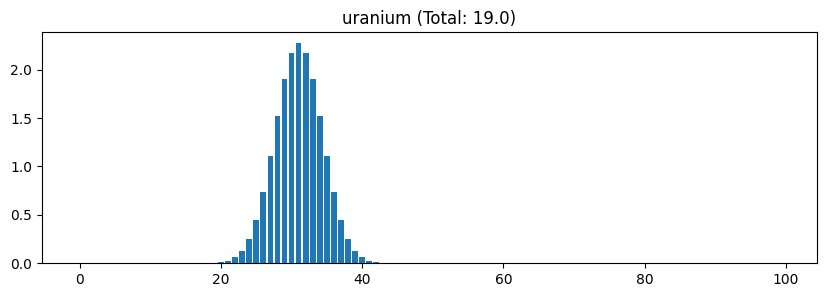

In [7]:
# @title
from IPython.display import clear_output
resource_names = list(resource_colors.keys())
plot_resource_dropdown = Dropdown(
    options=resource_names,
    value=resource_names[0]
)
def on_ground_view_dropdown_change(change):
  clear_output()
  display(plot_resource_dropdown)
  reporter.plot_resource(change["new"])
plot_resource_dropdown.observe(on_ground_view_dropdown_change, names="value")

display(plot_resource_dropdown)
reporter.plot_resource(resource_names[0])




In [ ]:
game.ground.resources

,toxicity,oil,coal,wood,uranium,gold
0,0.0,1.010454e-13,1.236524e-06,1.114600e-20,2.464438e-02,1.072207e-05
1,0.0,1.999676e-14,3.954639e-07,1.538920e-21,4.768176e-02,2.973439e-05
2,0.0,3.802163e-15,1.215177e-07,2.041461e-22,8.863697e-02,7.922598e-05
3,0.0,6.945925e-16,3.587568e-08,2.601923e-23,1.583090e-01,2.028170e-04
4,0.0,1.219152e-16,1.017628e-08,3.186222e-24,2.716594e-01,4.988494e-04
...,...,...,...,...,...,...
95,0.0,3.995779e-158,3.112546e-131,6.184898e-180,1.140217e-52,3.535245e-41
96,0.0,1.768990e-160,2.226901e-133,1.910339e-182,4.935178e-54,2.193213e-42
97,0.0,7.524497e-163,1.530786e-135,5.669132e-185,2.052326e-55,1.307285e-43
98,0.0,3.075090e-165,1.011012e-137,1.616408e-187,8.200081e-57,7.486661e-45


sum 68.41482789528835


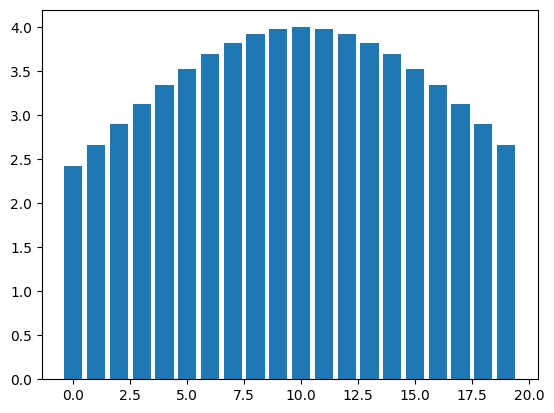

In [ ]:
resource_total = 100
resource_spread = 10
size = 20

center = 10 * 3
normal_dist = norm(loc=center, scale=resource_spread)
# create the spread across three "screens", then collapse to middle
distribution = normal_dist.pdf(range(size * 3))
distribution /= distribution.sum()
distribution *= resource_total
# get the center
distribution = distribution[size:size*2]

print("sum", distribution.sum())
plt.bar(x=range(size), height=distribution)
plt.show()

In [ ]:
grid_items:List[Label|Text] = [Label("Resource"), Label("Outside"), Label("Inside")]
resource_names = game.ground.get_resource_names()
for resource in resource_names:
  grid_items.append(Label(value=resource))
  grid_items.append(Text(value="0"))
  grid_items.append(Text(value="0"))
grid = GridBox(children=grid_items, layout=Layout(grid_template_columns="repeat(3, 100px)"))
display(grid)

GridBox(children=(Label(value='Resource'), Label(value='Outside'), Label(value='Inside'), Label(value='oil'), …

In [ ]:
i = 1
j = 2
grid_items[3*(i) + j].value

'0'

In [ ]:
grid.children[3*(i) + j].value

'0'